In [1]:
import librosa
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import soundfile as sf
import matplotlib.pyplot as plt

In [2]:
datset_path = "16000_pcm_speeches"

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
no_of_mfcc = 13

In [6]:
len_mfcc_window = 32

In [8]:
#get the lengthe of audio file
# 16000_pcm_speeches/Benjamin_Netanyau/1.wav
audio1,sr = librosa.load("16000_pcm_speeches/Benjamin_Netanyau/1.wav", sr=16000)
print(librosa.get_duration(path="16000_pcm_speeches/Benjamin_Netanyau/1.wav"))
mfccs1= librosa.feature.mfcc(y= audio1, sr= sr, n_mfcc=13)
print(mfccs1.shape)
print("Sampling rate" ,sr)

1.0
(13, 32)
Sampling rate 16000


In [40]:
def feature_extraction(parent_dir, speaker_folders,no_of_mfcc):
    features = []
    labels = []

    for i, speaker in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker)

        for file_name in os.listdir(speaker_folder_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path,file_name)
                audio , sr = librosa.load(file_path , sr= None)
                mfccs = librosa.feature.mfcc(y=audio, sr = sr, n_mfcc= no_of_mfcc) 
                ##testing
                # mfccs = mfccs[28]
                # mfccs= mfccs.reshape(-1,1)  
                
                ## padding and trimming
                if mfccs.shape[1] > len_mfcc_window:
                    mfccs = mfccs[:,:len_mfcc_window]
                else:
                    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, len_mfcc_window - mfccs.shape[1])), mode='constant')

                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(i)

    
    return np.array(features), np.array(labels)

X , Y = feature_extraction(datset_path, speaker_folders, no_of_mfcc, len_mfcc_window)

In [41]:
X.shape

(7501, 32, 13)

In [42]:
label_encoder = LabelEncoder()
Y= label_encoder.fit_transform(Y)
label_encoder.classes_= np.array(speaker_folders)

X_train, X_test , Y_train , Y_test = train_test_split(X,Y ,test_size= 0.6 , random_state= 42)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (3000, 32, 13)
Test Data Shape: (4501, 32, 13)


In [43]:
Y_test.shape

(4501,)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout

In [45]:
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


In [46]:
Y_test.shape

(4501, 5)

In [47]:
model = Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.Flatten(),    
    layers.Dense(416, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')   

])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 416)               173472    
                                                                 
 batch_normalization_1 (Batc  (None, 416)              1664      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2085      
                                                                 
Total params: 177,221
Trainable params: 176,389
Non-trainable params: 832
______________________________________________

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

In [49]:
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
94/94 [==============================] - 2s 12ms/step - loss: 0.5388 - accuracy: 0.8037 - val_loss: 0.6799 - val_accuracy: 0.7676
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 0.2927 - accuracy: 0.8957 - val_loss: 0.2262 - val_accuracy: 0.9189
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 0.2216 - accuracy: 0.9123 - val_loss: 0.1590 - val_accuracy: 0.9462
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 0.2135 - accuracy: 0.9180 - val_loss: 0.1466 - val_accuracy: 0.9511
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 0.1719 - accuracy: 0.9353 - val_loss: 0.1207 - val_accuracy: 0.9582
Epoch 6/100
94/94 [==============================] - 1s 9ms/step - loss: 0.1598 - accuracy: 0.9427 - val_loss: 0.1404 - val_accuracy: 0.9493
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 0.1362 - accuracy: 0.9500 - val_loss: 0.1293 - val_accuracy: 0.9553
Epoch 8/100


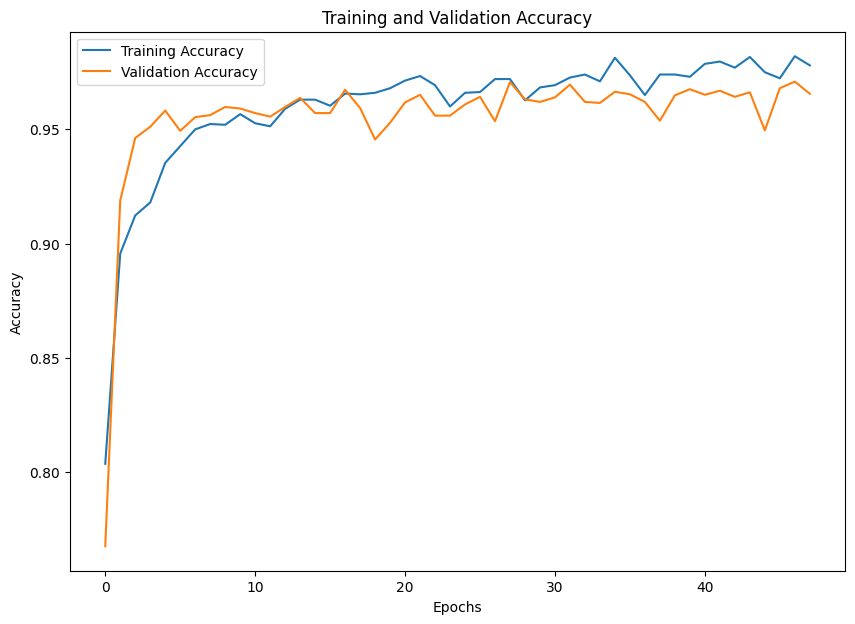

In [50]:
plt.figure(figsize=(10, 7))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [51]:
Y_predict = model.predict(X_test)
Y_predict = np.argmax(Y_predict, axis=1)

Y_test_flat = np.argmax(Y_test, axis=1)

141/141 [==============================] - 0s 2ms/step


In [52]:
#classification report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



class_report = classification_report(Y_test_flat, Y_predict, target_names=speaker_folders)
print(class_report)


                   precision    recall  f1-score   support

Benjamin_Netanyau       0.94      0.97      0.95       915
 Jens_Stoltenberg       0.97      0.92      0.95       891
    Julia_Gillard       0.98      0.99      0.98       890
  Magaret_Tarcher       0.96      0.98      0.97       903
   Nelson_Mandela       1.00      1.00      1.00       902

         accuracy                           0.97      4501
        macro avg       0.97      0.97      0.97      4501
     weighted avg       0.97      0.97      0.97      4501



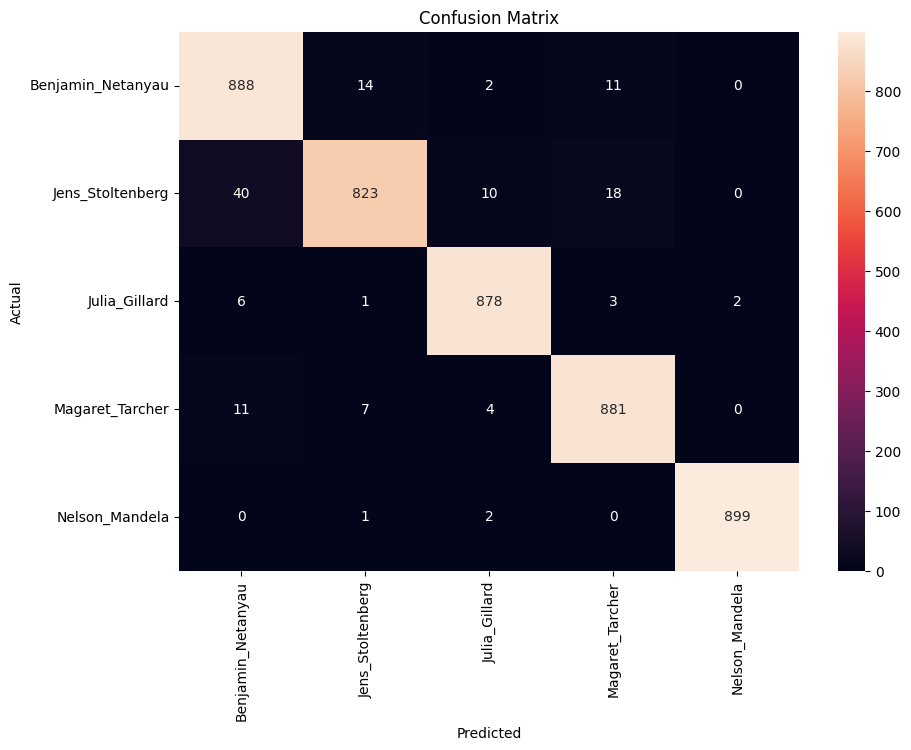

In [53]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(Y_test_flat, Y_predict), annot=True, fmt='d', xticklabels=speaker_folders, yticklabels=speaker_folders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()